# TP 2 : Grad-CAM - Deep Learning in Practice

## Student : Théo Di Piazza (theo.dipiazza@gmail.com)

## Master MVA - Ecole Normale Supérieure Paris-Saclay

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt
import urllib.request
import pickle

import cv2
import numpy as np

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [ ]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [ ]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
os.mkdir("data")
os.mkdir("data/TP2_images")
!cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

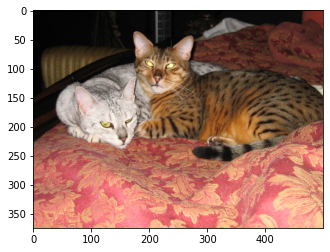

In [6]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [7]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.077121 10.977325 10.554378]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

# TP2 : Strategy

Without going into details, the objective of the method is to be able to know which neurons will be activated and will have a significant impact on the classification of the image by the model. The Grad-CAM method is implemented. This method must be implemented on a layer of interest. Here what we are interested in are the convolution layers, in particular the deepest layers. For this, we first try to know how to access the deepest convolution layer: we will work with the last convolution layer present in block 4 of the ResNet34 model, which precedes a batch-normalization.

Concerning the implementation, the first major step is to obtain the neuron importance weights $\alpha_{k}^{c}$ using the formula : 

$$\alpha_{k}^{c} = \frac{1}{Z}\sum_{i, j}\frac{\partial y^{c}}{\partial A_{jj}^{k}}$$

In a second step, obtain a coarse heat map through a weighted combination of forward activation maps, and follow it with a ReLU to obtain:

$$L_{Grad-CAM}^{c} = ReLU\left( \sum_{k} \alpha_{k} A^{k} \right)$$

For more details, please check the paper (https://arxiv.org/pdf/1610.02391.pdf).

# Code of TP2

## Explore layers of interest

Explore architecture of ResNet34 to see which layer can be use for visualization of CNN. For more details about ResNet : https://arxiv.org/abs/1512.03385

In [8]:
# Modules of the model resnet34
resnet34._modules.keys()

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [22]:
# Modules of the last block which contains a convolutional layer
resnet34.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
# Module of the last convolutional layer
resnet34.layer4[-1].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [23]:
# Module that comes after the last convolutional layer
resnet34.layer4[-1].bn2

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

## Implement GradCAM function

In [26]:
#@title get_gradCAM function
def get_gradCAM(img_input, img_display, index_sample):
  '''
  From input of the model, image to display and index of the sample.
  Returns the merged_map of the 3 first classes.
  '''

  rgb_limit = 255 # parameter for cv2

  # Function to save features (forward activation maps) values during forward propagation
  def activations_hook_forward(module, input, output):
    '''
      Function run at module with input and output, during forward propagation.
      Activate hook with 'model_name.layer_name.register_forward_hook(activations_hook_forward)'
      Run when 'output = model(input)'
    '''
    layer_hook_features.append(output)

  # Function to save gradients values during backward propagation
  def activations_hook_backward(module, input, output):
    '''
      Function run at module with input and output, during backward propagation.
      Activate hook with 'model_name.layer_name.register_backward_hook(activations_hook_backward)'
      Run when 'loss.backward()'
    '''
    layer_hook_gradients.append(output)

  # initialize model
  resnet34 = models.resnet34(pretrained=True)
  resnet34.eval()

  # add hook to layers of interest
  handle_forward = resnet34.layer4[-1].bn2.register_forward_hook(activations_hook_forward)
  handle_backward = resnet34.layer4[-1].bn2.register_backward_hook(activations_hook_backward)

  # initialize gradients, features
  layer_hook_gradients, layer_hook_features = [], []

  output = resnet34(img_input)
  _, indices = torch.topk(output, 3) # top 3 classes

  heatmaps_merged, classes_predicted = [], [] # stock 3 heatmaps and 3 classes predicted

  # iterate over each class
  for index_predicted_class in indices[0].numpy():

    # initialize and backpropagation
    signal = torch.zeros(output.shape)
    signal[:, index_predicted_class] = output[:, index_predicted_class]
    resnet34.zero_grad()
    torch.sum(signal).backward(retain_graph=True)

    # compute neuron importance weights (1) from paper
    weights = torch.mean(layer_hook_gradients[0][0], (0, 1))
    relu = nn.ReLU()

    # compute coarse hetmap (2) from paper
    heatmap_coarse = relu(torch.sum(weights * layer_hook_features[0][0], 0))

    # compute heatmap with bilienar interpolation (7*32=224)
    heatmap = F.interpolate(heatmap_coarse.view(1, 1, 7, 7), scale_factor=32, mode='bilinear')
    heatmap = heatmap[0][0]/torch.max(heatmap) # normalize
    heatmap = heatmap.detach().numpy() # detach grad
    heatmap = cv2.applyColorMap(np.uint8(rgb_limit*heatmap), cv2.COLORMAP_JET) 
    heatmap = np.float32(heatmap)/rgb_limit

    # merge image and heatmap
    current_heatmap_merged = cv2.addWeighted(heatmap, 0.5, img_display, 0.5, 0)
    current_heatmap_merged = np.uint8(rgb_limit * current_heatmap_merged[:, :, ::-1])
    heatmaps_merged.append(current_heatmap_merged)
    classes_predicted.append(classes[index_predicted_class])

  handle_forward.remove()
  handle_backward.remove()

  return heatmaps_merged, classes_predicted

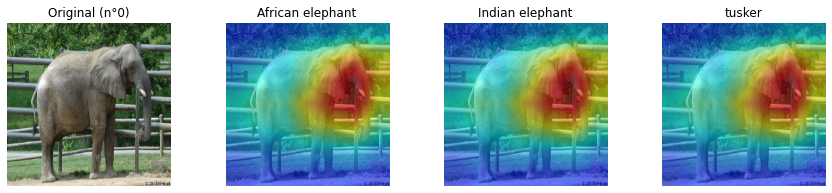

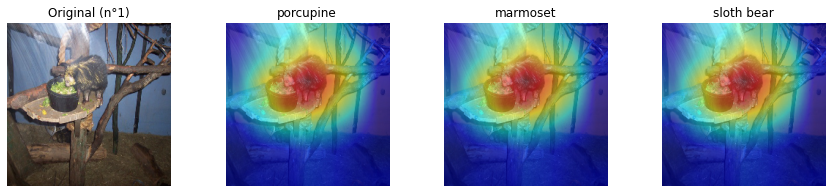

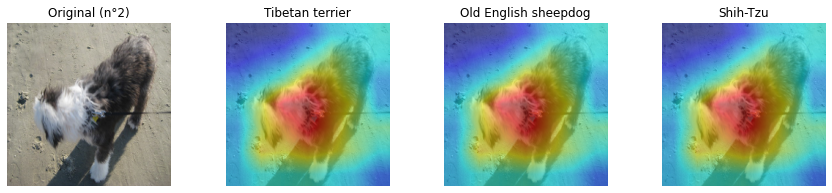

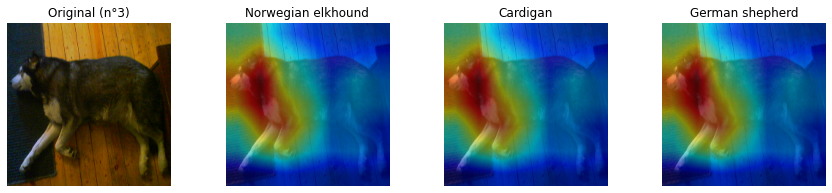

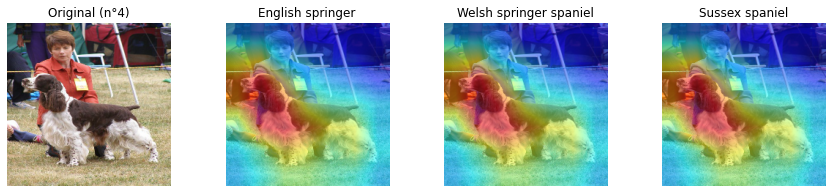

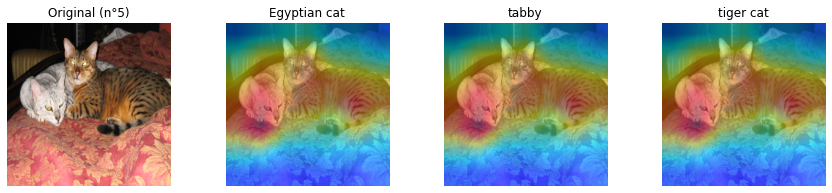

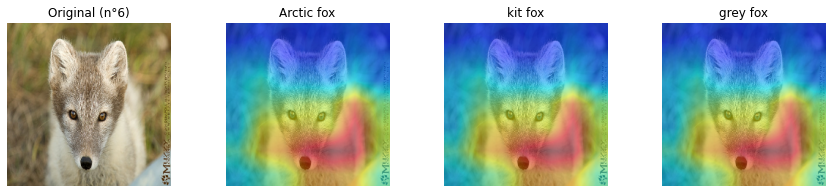

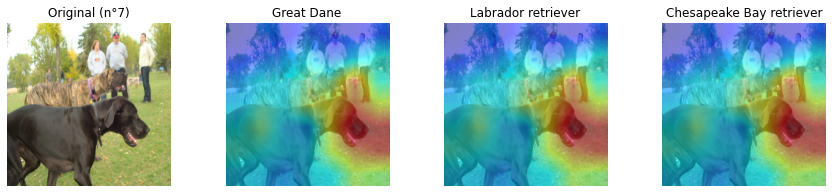

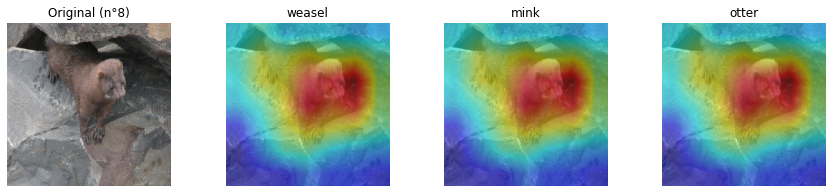

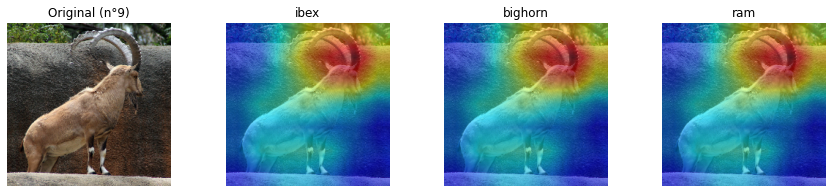

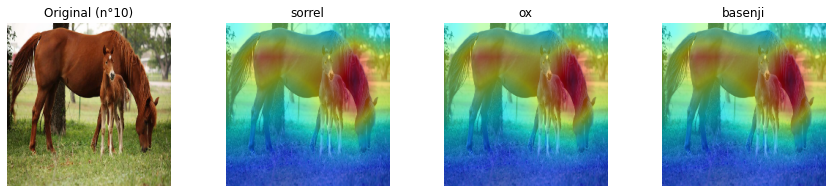

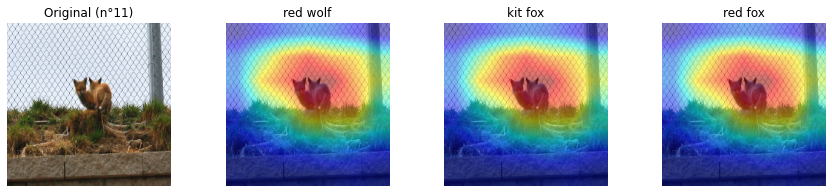

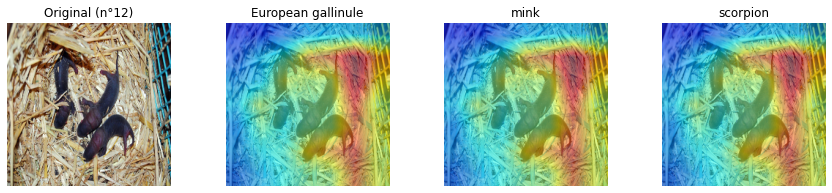

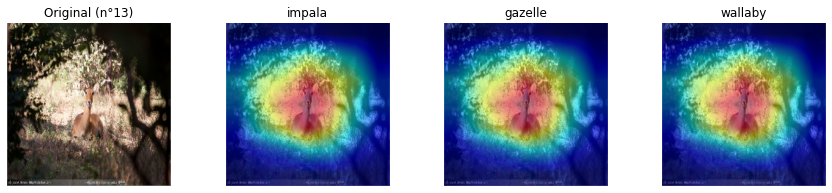

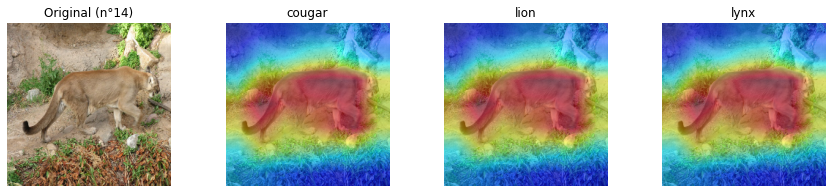

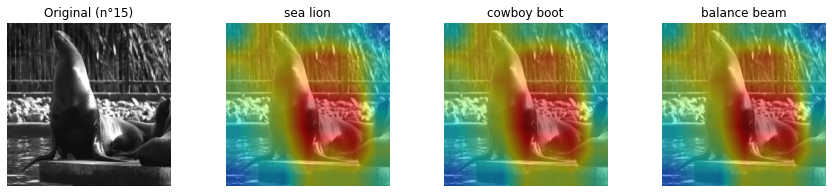

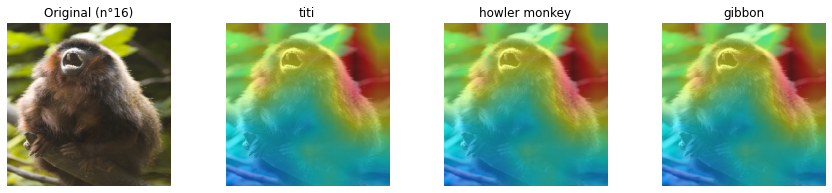

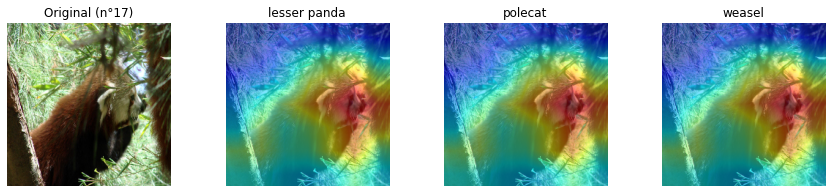

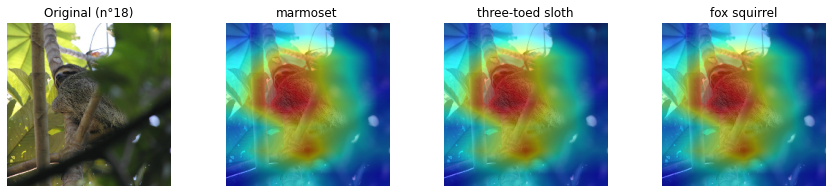

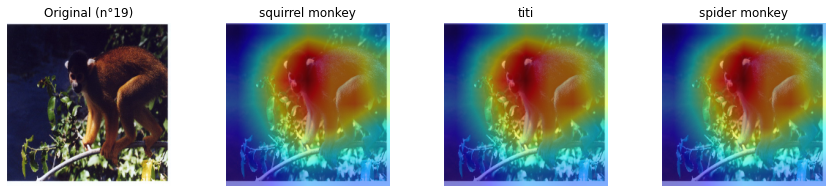

In [27]:
#@title Run over 20 samples

# iterate over each sample
for index_sample in range(len(dataset)):
  
  # get image as input and image to display
  img_input = dataset[index_sample][0].view(1, 3, 224, 224) # input of the model
  img_display = np.array(Image.open(dataset.imgs[index_sample][0]).convert('RGB')) # image to display
  img_display = np.float32(cv2.resize(img_display, (224, 224))) / 255 # to numpy

  heatmaps_sample, classes_samples = get_gradCAM(img_input, img_display, index_sample) # get 3 merged heatmaps

  # plot images
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
  axes[0].imshow(img_display); axes[0].set_title(f'Original (n°{index_sample})');
  axes[1].imshow(heatmaps_sample[0]); axes[1].set_title(classes_samples[0].split(',')[0]);
  axes[2].imshow(heatmaps_sample[1]); axes[2].set_title(classes_samples[1].split(',')[0]);
  axes[3].imshow(heatmaps_sample[2]); axes[3].set_title(classes_samples[2].split(',')[0]);
  axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off'); axes[3].axis('off');
  plt.show()

## Observations

We see that for the majority of the images, the model is able to detect the class of the animal thanks to features consistent with the image. Thanks to the GradCAM method, we can see that in some cases, the model "recognizes" the whole body of the animal (Sample 5, 11, 19). In other cases, it uses only a part of its body (horn, tail...) very singular to the animal to recognize it (0, 2, 3, and so on...).

For a given imagine, when we look at the top 3 classes predicted by the model, we see that the classes are often very close to each other, and in some cases correspond to different breeds of the same animal (for example for sample 6: artic, kit and grey fox are recognized). In these cases, by observing the heatmap, we can see that the model extracts almost the same features: this is consistent because animals of different breeds of the same species have many physical attributes in common.

To summarize the feature extraction: the model seems to be particularly good at extracting features that are specific to each animal, but less efficient at extracting features that differentiate races (or animals that look alike).